In [1]:
%pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
import os
from tqdm import tqdm

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters

In [3]:
# subscription_id="36ac59f4-4776-4409-ab97-fbcd4213ea32"
# resource_group_name="n.v.selivanov-rg"
# workspace_name="sweet-paws"
# datastore_name = "workspaceblobstore"

data_uri = f"https://sweetpaws5552855935.blob.core.windows.net/azureml-blobstore-fa7a92d8-39c7-427a-b9b4-116ce9a104ba/fer2013.zip"
data_path = "/home/azureuser/protofer/data/fer2013"

# Download Data

In [4]:
# !mkdir /home/azureuser/data

In [5]:
# !azcopy logout
# !azcopy login --tenant-id=81aa9791-5f20-4a63-9ee9-94df31fad662

In [6]:
# !azcopy cp {data_uri} {data_path}

In [7]:
# !unzip "/home/azureuser/data/fer2013.zip" -d "/home/azureuser/data"

# Data Transforms

In [8]:
train_transforms = A.Compose(
    [
        # A.SmallestMaxSize(max_size=350),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        # A.RandomCrop(height=256, width=256),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5, 2], per_channel=True, p=0.2),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Normalize(mean=.45, std=0.225),
        # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = train_transforms

# test_transforms = A.Compose(
#     [
#         # A.SmallestMaxSize(max_size=350),
#         # A.CenterCrop(height=256, width=256),
#         # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.Normalize(mean=.45, std=0.225),
#         ToTensorV2(),
#     ]
# )

# Data
## Prepare

In [9]:
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

In [10]:
classes = []
train_image_paths = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*.jpg'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

classes

['neutral', 'surprise', 'fear', 'angry', 'disgust', 'sad', 'happy']

In [11]:
# Split train and valid datasets
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

In [12]:
# Test dataset
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

In [13]:
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 22967
Valid size: 5742
Test size: 7178


In [14]:
# Encode classes
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

## Class Counts
### Train

In [15]:
print('~~~ TRAIN ~~~')
for cls in classes:
    print(f'{cls} images: {len(os.listdir(os.path.join(train_data_path, cls)))}')

print('~~~ TEST ~~~')
for cls in classes:
    print(f'{cls} images: {len(os.listdir(os.path.join(test_data_path, cls)))}')

~~~ TRAIN ~~~
neutral images: 4965
surprise images: 3171
fear images: 4097
angry images: 3995
disgust images: 436
sad images: 4830
happy images: 7215
~~~ TEST ~~~
neutral images: 1233
surprise images: 831
fear images: 1024
angry images: 958
disgust images: 111
sad images: 1247
happy images: 1774


## Dataset Class

In [16]:
class FerDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [17]:
train_dataset = FerDataset(train_image_paths, train_transforms)
valid_dataset = FerDataset(valid_image_paths, test_transforms)
test_dataset = FerDataset(test_image_paths, test_transforms)

In [18]:
print('The shape of tensor for 50th image in train dataset: ', train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ', train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([1, 48, 48])
The label for 50th image in train dataset:  3


## Visualize Augmented Images

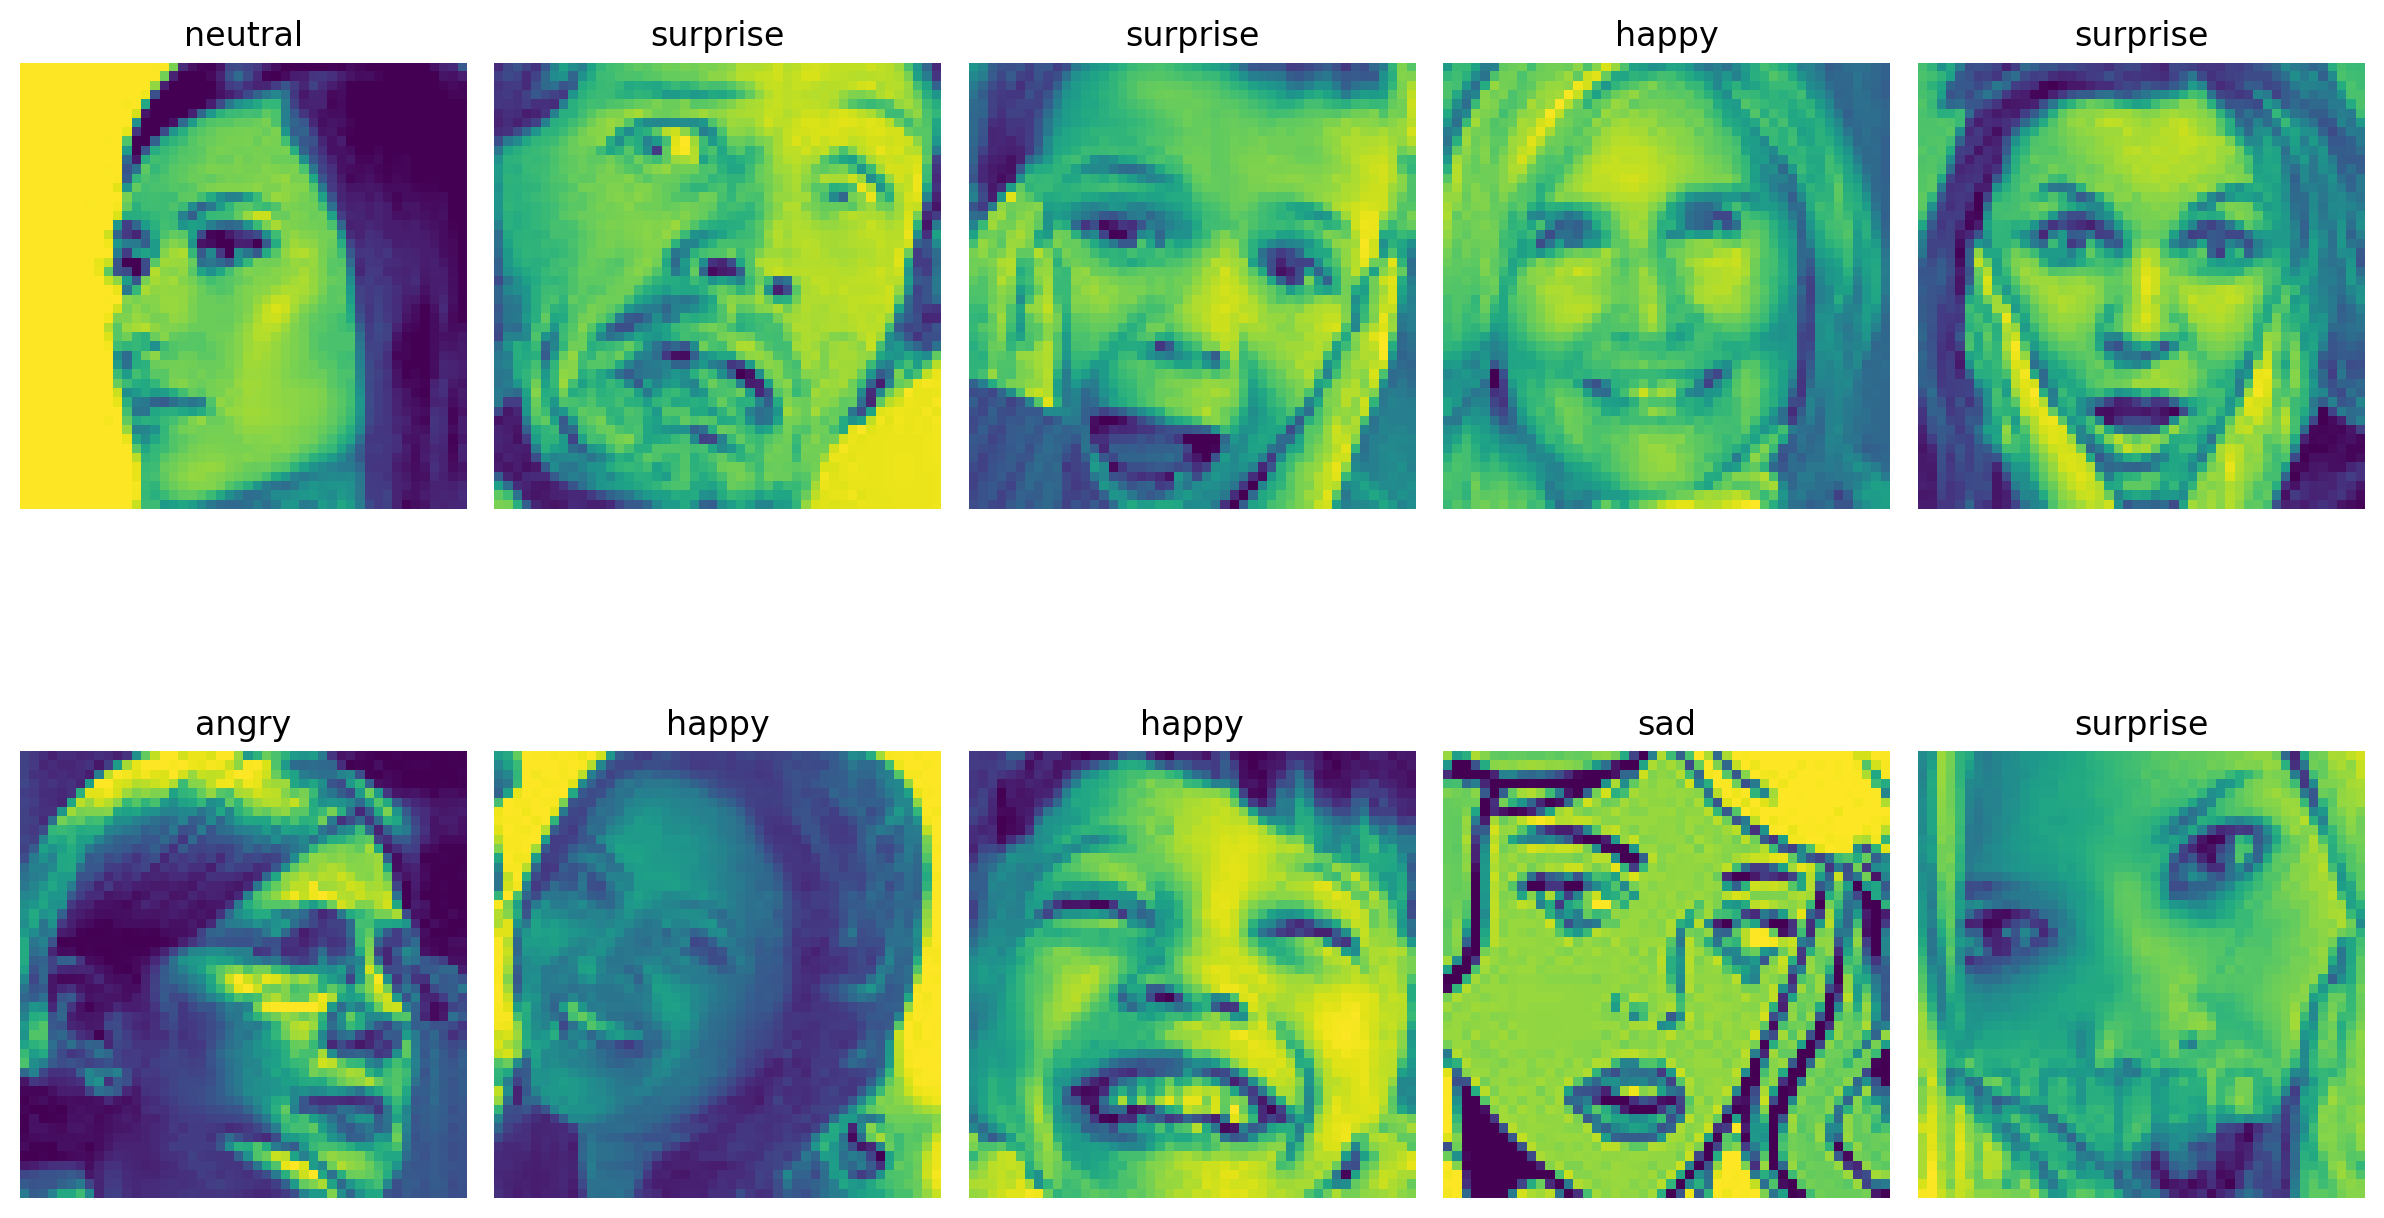

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline


def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
      
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

## Data Loaders

In [20]:
batch_size = 2

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [21]:
tl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
images, labels = next(iter(tl))
print(images.shape)

torch.Size([2, 1, 48, 48])


In [22]:
image = images[0, 0, :, :]
image.shape

torch.Size([48, 48])

In [23]:
for i in range(48):
    print(image[i, i])

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.1890)
tensor(0.1169)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.8924)
tensor(0.)
tensor(0.)


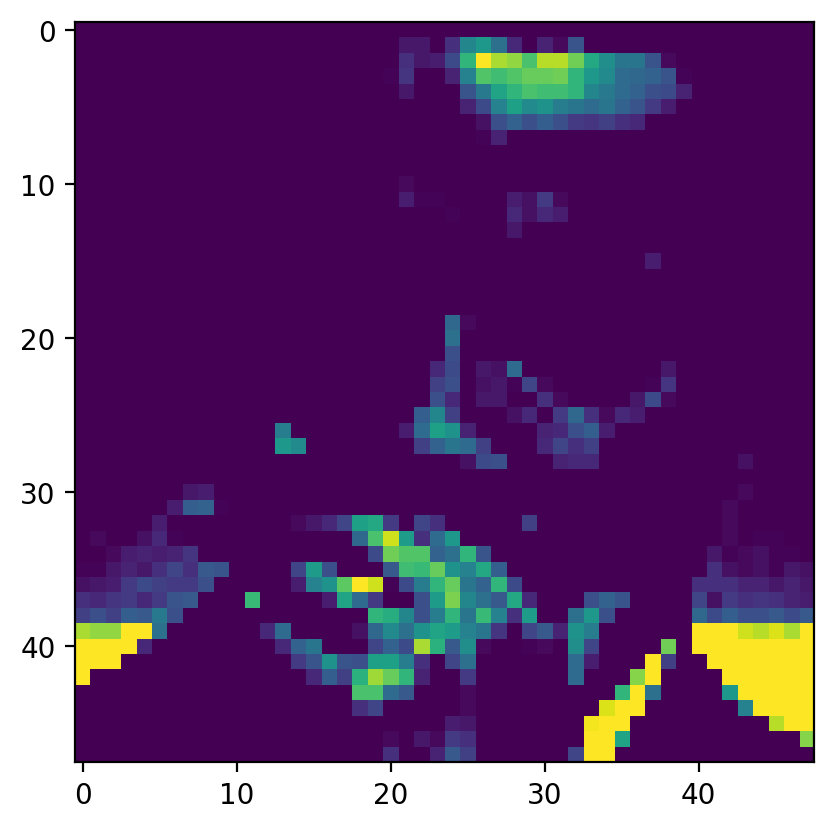

In [24]:
plt.imshow(image)

# Training

Implementing Model B:
![cnn-diagram](https://github.com/amineHorseman/facial-expression-recognition-using-cnn/raw/master/img/CNN_models_architecture.png)

In [25]:
# Define relevant variables for the ML task
num_classes = len(classes)
learning_rate = 0.001
num_epochs = 100

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2)
        self.dropout1 = nn.Dropout2d(p=.8)
        self.relu1 = nn.ReLU()
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout2d(p=.8)
        self.relu2 = nn.ReLU()
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.dropout3 = nn.Dropout3d(p=.8)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(3200, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.dropout1(out)
        out = self.relu1(out)

        out = self.conv_layer2(out)
        out = self.dropout2(out)
        out = self.relu2(out)
        
        out = self.conv_layer3(out)
        out = self.dropout3(out)
        out = self.relu3(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [28]:
m = ConvNeuralNet(num_classes)
params = sum(p.numel() for p in m.parameters())
params

503527

In [29]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            weight_decay=0.005,
                            momentum = 0.9)  

total_step = len(train_loader)

model.to(device)

# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

Epoch [1/100], Loss: 2.0262
Epoch [2/100], Loss: 1.4045
Epoch [3/100], Loss: 1.7852
Epoch [4/100], Loss: 1.7959
Epoch [5/100], Loss: 2.1782
Epoch [6/100], Loss: 1.7237
Epoch [7/100], Loss: 1.4078
Epoch [8/100], Loss: 1.9410
Epoch [9/100], Loss: 1.7469
Epoch [10/100], Loss: 2.0040
Epoch [11/100], Loss: 1.4866
Epoch [12/100], Loss: 1.7733
Epoch [13/100], Loss: 1.8135
Epoch [14/100], Loss: 2.0296
Epoch [15/100], Loss: 1.9449
Epoch [16/100], Loss: 1.4271
Epoch [17/100], Loss: 1.8960
Epoch [18/100], Loss: 1.6914
Epoch [19/100], Loss: 1.3904
Epoch [20/100], Loss: 1.3545
Epoch [21/100], Loss: 1.9199
Epoch [22/100], Loss: 1.8920
Epoch [23/100], Loss: 1.9209
Epoch [24/100], Loss: 1.9969
Epoch [25/100], Loss: 1.4582
Epoch [26/100], Loss: 2.0025
Epoch [27/100], Loss: 1.8978
Epoch [28/100], Loss: 1.9618
Epoch [29/100], Loss: 3.8958
Epoch [30/100], Loss: 1.7011
Epoch [31/100], Loss: 1.8860
Epoch [32/100], Loss: 1.3870
Epoch [33/100], Loss: 1.4102
Epoch [34/100], Loss: 2.2591
Epoch [35/100], Loss: 1

Bad pipe message: %s [b'\xa0l\x90\x17\xd8\xbe;\xf1@\x13']
Bad pipe message: %s [b"\xd1\xa0rp\x8fI )\xaa\t\xd8\x96\x9c\xa5\x98\xe77{#\\\x94\x02\xdcW\xf1\xfc\xe3\xe9\x8b\xf8\xb1.*\xf7wt%'{\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00"]
Bad pipe message: %s [b'\x1d\x00 \xc8\xbf\x8a-\xd5\x83|\x1a?\xdaKcw[\xe3\xae+v\xf6%\xf9\xa9tMmG\x8c\xa3\x1d\xd6\xa3d']
Bad pipe message: %s [b"\xa2;\x9e\xf0)\xf2\xbf#6\xccK=#\x15\x18l\xa0\x9e\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0

Epoch [79/100], Loss: 1.4278
Epoch [80/100], Loss: 1.9710
Epoch [81/100], Loss: 2.1946
Epoch [82/100], Loss: 1.4528
Epoch [83/100], Loss: 1.6280
Epoch [84/100], Loss: 1.4484
Epoch [85/100], Loss: 2.0927
Epoch [86/100], Loss: 1.7937
Epoch [87/100], Loss: 2.2727
Epoch [88/100], Loss: 1.3625
Epoch [89/100], Loss: 1.7902
Epoch [90/100], Loss: 1.3918
Epoch [91/100], Loss: 1.3439
Epoch [92/100], Loss: 1.4257
Epoch [93/100], Loss: 1.3435
Epoch [94/100], Loss: 1.9166
Epoch [95/100], Loss: 1.7181
Epoch [96/100], Loss: 1.9610
Epoch [97/100], Loss: 1.9183
Epoch [98/100], Loss: 2.1818
Epoch [99/100], Loss: 1.5189
Epoch [100/100], Loss: 1.4018
